In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split

import tensorflow_addons as tfa

In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
DATA_QBITS = 16
LATENT_QBITS = 4
TOTAL_QBITS = DATA_QBITS

INPUT_DATA_SIZE = 9 # image width

DRCs = 2

### data 

In [4]:
test = h5py.File("small_quark_gluon_12","r")

x_s = test.get('X')
y_s = test.get('y')

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_s[:],
                                                  y_s[:],
                                                  test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    test_size=0.4, shuffle=True)

In [6]:
x_train_1 = x_train[y_train==1]
x_train = x_train[y_train==0]

x_val_1 = x_val[y_val==1]
x_val = x_val[y_val==0]

x_test_1 = x_test[y_test==1]
x_test = x_test[y_test==0]

In [7]:
div = np.max(x_train_1,axis=(1,2)).reshape(x_train_1.shape[0],1,1)
div[div == 0] = 1
x_train_1 = x_train_1 / div
div = np.max(x_train,axis=(1,2)).reshape(x_train.shape[0],1,1)
div[div == 0] = 1
x_train = x_train / div

div = np.max(x_val_1,axis=(1,2)).reshape(x_val_1.shape[0],1,1)
div[div == 0] = 1
x_val_1 = x_val_1 / div
div = np.max(x_val,axis=(1,2)).reshape(x_val.shape[0],1,1)
div[div == 0] = 1
x_val = x_val / div

div = np.max(x_test_1,axis=(1,2)).reshape(x_test_1.shape[0],1,1)
div[div == 0] = 1
x_test_1 = x_test_1 / div
div = np.max(x_test,axis=(1,2)).reshape(x_test.shape[0],1,1)
div[div == 0] = 1
x_test = x_test / div

### circuit

In [8]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [9]:
def single_upload(params, data, wire):
    for i, d in enumerate(tf.reshape(data, [-1])):
        if i % 3 == 0:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 1:
            qml.RY(params[i * 2] + params[i * 2 + 1] * d, wires=wire)
        if i % 3 == 2:
            qml.RZ(params[i * 2] + params[i * 2 + 1] * d, wires=wire)

def conv_upload(params, img, kernel_size, stride, wires):
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))*len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))
    params_per_upload = len(params) // number_of_kernel_uploads
    upload_counter = 0
    wire = 0
    for y in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
        for x in range(0,INPUT_DATA_SIZE-kernel_size+1,stride):
            single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
                          img[y:y+kernel_size, x:x+kernel_size], wires[wire])
            upload_counter = upload_counter + 1
            wire = wire + 1
    #for y in range(0, INPUT_DATA_SIZE ** 2, stride ** 2):
    #    single_upload(params[upload_counter * params_per_upload: (upload_counter + 1) * params_per_upload],
    #                  img[y:y+stride**2], wires[wire])
    #    upload_counter = upload_counter + 1
    #    wire = wire + 1
            
def circular_entanglement(wires):
    qml.CNOT(wires=[wires[-1], 0] )
    for i in range(len(wires)-1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev1, diff_method="adjoint")
def circuit(inputs, weights):
    #inputs = inputs.numpy()
    kernel_size = 3
    stride = 2
    #print(weights)
    #print(inputs)
    #inputs = inputs.reshape(INPUT_DATA_SIZE, INPUT_DATA_SIZE)
    #print(inputs.shape)
    inputs = tf.reshape(inputs, [INPUT_DATA_SIZE, INPUT_DATA_SIZE])
    
    number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
    num_upload_params = number_of_kernel_uploads*2*kernel_size**2
    
    for i in range(DRCs):
        conv_upload(weights[i*num_upload_params:(i+1)*num_upload_params], inputs, kernel_size, stride, list(range(number_of_kernel_uploads)))
        circular_entanglement(list(range(number_of_kernel_uploads)))

    return [qml.expval(qml.PauliZ(i)) for i in range(TOTAL_QBITS)]

In [10]:
data = np.random.rand(INPUT_DATA_SIZE*INPUT_DATA_SIZE)

kernel_size = 3
stride = 2
number_of_kernel_uploads = len(list(range(0,INPUT_DATA_SIZE-kernel_size+1,stride)))**2
num_upload_params = number_of_kernel_uploads*2*kernel_size**2

2022-09-15 07:47:16.950861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 07:47:16.957318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 07:47:16.957713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 07:47:16.958685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

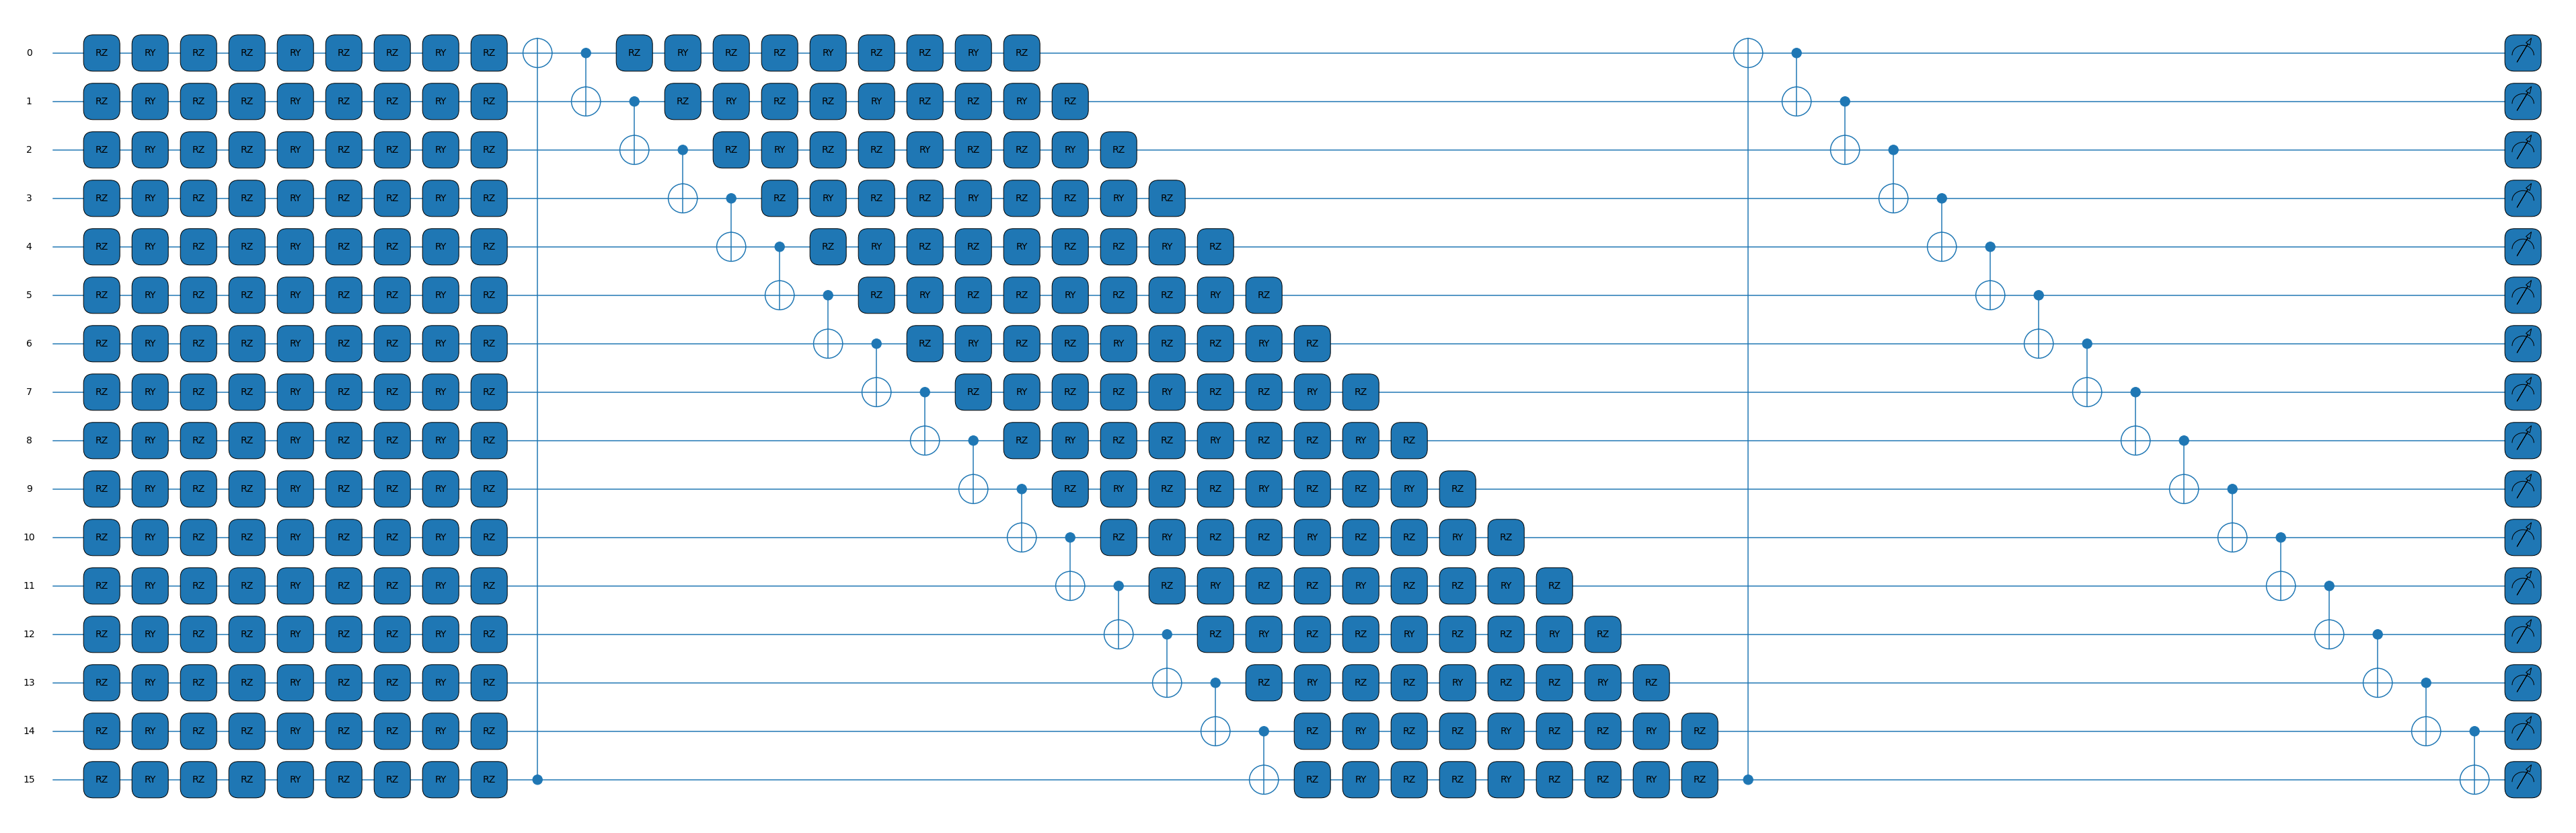

In [11]:
fig, ax = qml.draw_mpl(circuit)(data,np.ones(DRCs*num_upload_params))
fig.show()

In [12]:
weight_shapes = {"weights": (DRCs*num_upload_params,)}

In [13]:
qlayer = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=TOTAL_QBITS)

### hybrid

In [14]:
inputs = tf.keras.layers.Input(shape=(12,12,1))
clayer_1 = tf.keras.layers.Conv2D(12, 4, strides=1, padding='valid', activation="relu")
clayer_2 = tf.keras.layers.Conv2D(10, 2, strides=1, padding='same', activation="relu")
clayer_3 = tf.keras.layers.Conv2D(1, 2, strides=1, padding='same', activation="relu")
dress1 = tf.keras.layers.Flatten()

#dress1 = tf.keras.layers.Reshape((9*9,))
dress2 = tf.keras.layers.Dense(81)
re = tf.keras.layers.Reshape((9,9,1))
clayer_4 = tf.keras.layers.Conv2DTranspose(12, 4, strides=1, padding='valid', activation="relu")
clayer_5 = tf.keras.layers.Conv2D(10, 2, strides=1, padding='same', activation="relu")
out_layer = tf.keras.layers.Conv2D(1, 2, strides=1, padding='same', activation="sigmoid")

In [15]:
model = tf.keras.models.Sequential([inputs, clayer_1, clayer_2, clayer_3, dress1, qlayer, dress2, re, clayer_4, clayer_5, out_layer])

In [16]:
import tensorflow_addons as tfa
optw = tfa.optimizers.AdamW(weight_decay=0.001,learning_rate=0.001)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(opt, loss="bce")

In [18]:
model.build(input_shape=(12,12,1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 12)          204       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 10)          490       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 16)                0 (unused)
                                                                 
 dense (Dense)               (None, 81)                1377      
                                                                 
 reshape (Reshape)           (None, 9, 9, 1)           0

In [20]:
x_train_small = x_train[:10000]
x_test_small = x_test[:1200]

x_train_1_small = x_train_1[:10000]
x_test_1_small = x_test_1[:1200]

In [21]:
print(x_train_small.shape)
print(x_test_small.shape)

print(x_train_1_small.shape)
print(x_test_1_small.shape)

(10000, 12, 12)
(1200, 12, 12)
(10000, 12, 12)
(1200, 12, 12)


In [22]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.metrics import jaccard_score
import numpy as np
import os
from sklearn.metrics import roc_auc_score

class auc_eval_metric(keras.callbacks.Callback):
    """Computes the Jaccard score and logs the results to TensorBoard."""

    def __init__(self, model, x_test_bg, x_test_signal):
        self.model = model
        self.x_test_bg = x_test_bg.reshape(x_test_bg.shape + (1,))
        self.x_test_signal = x_test_signal.reshape(x_test_signal.shape + (1,))
        self.keras_metric = tf.keras.metrics.Mean("eval_auc")
        self.epoch = 0
        self.history = []

    def on_epoch_end(self, batch, logs=None):
        self.epoch += 1
        self.keras_metric.reset_state()
        
        bg_recon = self.model.predict(self.x_test_bg)
        signal_recon = self.model.predict(self.x_test_signal)
        
        bce_bg = tf.keras.losses.binary_crossentropy(self.x_test_bg, bg_recon, axis=(1,2,3)).numpy()
        bce_signal = tf.keras.losses.binary_crossentropy(self.x_test_signal, signal_recon, axis=(1,2,3)).numpy()
        
        y_true = np.append(np.zeros(len(bce_bg)),np.ones(len(bce_signal)))
        y_pred = np.append(bce_bg, bce_signal)
        
        auc = roc_auc_score(y_true, y_pred)
        
        self.history.append(auc)
        
        self.keras_metric.update_state(auc)

In [23]:
auc = auc_eval_metric(model, x_test_1_small, x_test_small)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=1e-5)
fitting = model.fit(x_train_1_small, x_train_1_small, 
                    epochs=20, 
                    batch_size=64, 
                    steps_per_epoch=100, 
                    validation_data=(x_test_1_small, x_test_1_small), 
                    callbacks=[es,auc])

Epoch 1/20
100/100 [==============================] - 6720s 67s/step - loss: 0.0331 - val_loss: 0.0349
Epoch 2/20
 30/100 [========>.....................] - ETA: 1:09:05 - loss: 0.0341

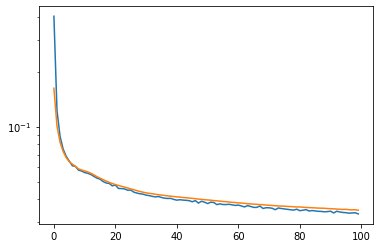

In [25]:
import matplotlib.pyplot as plt
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.yscale("log")

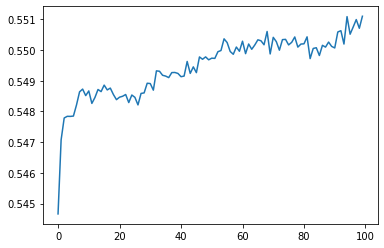

In [26]:
plt.plot(auc.history)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 12)          204       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 10)          490       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 1)           41        
                                                                 
 flatten (Flatten)           (None, 81)                0         
                                                                 
 keras_layer (KerasLayer)    (None, 16)                576       
                                                                 
 dense (Dense)               (None, 81)                1377      
                                                                 
 reshape (Reshape)           (None, 9, 9, 1)           0

Collapse_metric: 0.878
Average EMD: 3.88
ssim: 0.786
MAE: 0.0134
normalized MAE: 0.0067


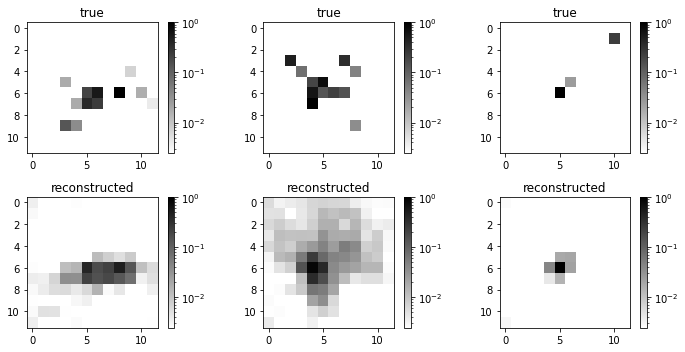

In [28]:
from hep_VQAE import utils as ut

recon = model.predict(x_test_1_small[:400])

ut.eval_recon(x_test_1_small[:400], recon, lognorm=True)

Median background: 0.0281
Median signal: 0.0328
Maximum accuracy: 0.546
AUC: 0.551


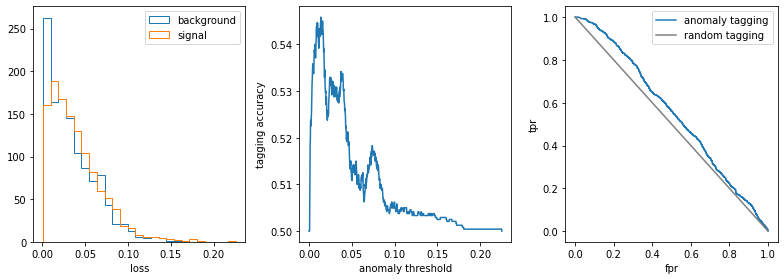

In [29]:
recon = model.predict(x_test_1_small)
recon_1 = model.predict(x_test_small)

ut.eval_tagging(x_test_1_small, recon, x_test_small, recon_1)

Collapse_metric: 0.854
Average EMD: 4.41
ssim: 0.754
MAE: 0.0151
normalized MAE: 0.00699


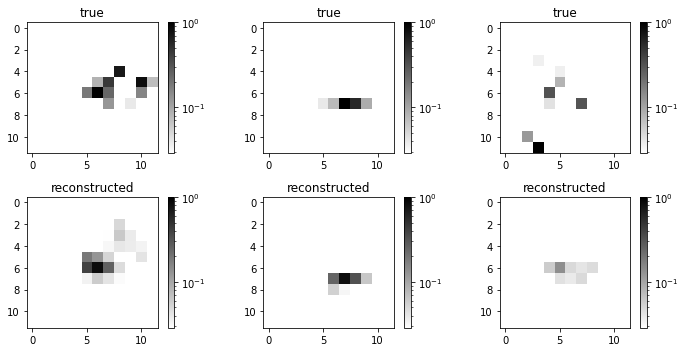

In [30]:
ut.eval_recon(x_test_small, recon_1, lognorm=True)